<a href="https://colab.research.google.com/github/PTC-Education/PTC-API-Playground/blob/main/Onshape_GIF_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello World Onshape API
This notebook shows how to use Onshape's REST API to create a GIF from an Onshape Assembly. You will use the API to make assemblies move, update the color and opacity of parts, and get a shaded image of the current view of the assembly. [Getting started video linked here](https://www.youtube.com/watch?v=5QCpUdMQbs0).

Befor you get started, you should know a little bit about Onshape and Python.

* Onshape
  * The difference between a Part Studio and an Assembly
  * How to make a part in a Part Studio
  * How to create a mate in an Assembly
* Python
  * What a function is
  * What a for loop is
  * What an array is

You can find a [full library of snippets in this notebook](https://colab.research.google.com/github/PTC-Education/PTC-API-Playground/blob/main/Onshape_API_Snippets.ipynb) and you can check out [more example notebooks on this page](https://ptc-education.github.io/docs/solutions/onshapedx).

## Set up Onshape client
You will first need to go to the [Onshape Dev Portal](https://dev-portal.onshape.com/) and generate API keys. Select "no enterprise" if your document starts with "cad.onshape.com/...." and the first three options for key access. Then run the cell below to configure the Onshape API Client.

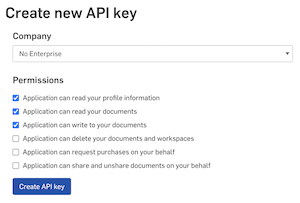

In [ ]:
#@title Import and Setup Onshape Client

!pip install onshape-client
from onshape_client.client import Client
from onshape_client.onshape_url import OnshapeElement
import json

#@markdown Chage the base if using an enterprise (i.e. "https://ptc.onshape.com")
base = 'https://cad.onshape.com' #@param {type:"string"}

#@markdown Would you like to import your API keys from a file, or copy and paste them directly?
keyImportOption = "Upload Keys from File" #@param ["Upload Keys from File", "Copy/Paste Keys"]

from IPython.display import clear_output 
clear_output()
print("Onshape Client successfully imported!")

if keyImportOption == "Upload Keys from File":
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    execfile(fn)

  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')
else:
  access = input("Paste your Onshape Access Key: ")
  secret = input("Paste your Onshape Secret Key: ")
  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')


Onshape client configured - ready to go!


## Define Mate Motion Functions

First run the cell below to see the values of the mates in your assembly. You can drag the parts in your assembly to move them around, then run the cell again to make sure the values are updated. **Note: this will not work if you have movable mates in a sub assembly**

In [ ]:
#@title Get Mates from Assembly
#@markdown Defines function `getAssemblyMates(url)`, which returns JSON of mates in an assembly

#@markdown Paste your URL below (must be an Assembly URL)
url = 'https://cad.onshape.com/documents/949db49d403f8dda0a38939e/w/bb9082de5d7f8a3994b5f694/e/09def4e24ce0168b59242e48' #@param {type:"string"}
showResponse = True #@param {type:"boolean"}

def getAssemblyMates(url):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/matevalues'
  element = OnshapeElement(url)
  method = 'GET'

  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v2+json',
              'Content-Type': 'application/vnd.onshape.v2+json'}

  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  return parsed

if showResponse:
  mates = getAssemblyMates(url)
  print(json.dumps(mates, indent=4, sort_keys=True))
else:
  pass

Now you can run this cell to update the mate values. Input the name of the mate you want to update and the position. **Note: this will only work for 1 degree of freedom mates (slider or revolute)**

In [ ]:
#@title Set Mates in Assembly
#@markdown Defines funciton `setMateByName(url,mateName,position)`, which updates the mate with the specified name to the specified position

#@markdown Paste your URL below (must be an Assembly URL)
url = 'https://cad.onshape.com/documents/fb00ed566c3e0934ae91d74c/w/80749fc9b1aa0adab776dc56/e/f17ce18736063f03b8d7dd9a' #@param {type:"string"}
#@markdown Input the exact name of your mate feature from the assembly
mateName = "Slider 1" #@param {type:"string"}
#@markdown Input the new position for the mate (revolute will be in radians, slider will be in meters)
position =  0.4#@param {type:"number"}
showResponse = False #@param {type:"boolean"}

def getAssemblyMates(url):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/matevalues'
  element = OnshapeElement(url)
  method = 'GET'

  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v2+json',
              'Content-Type': 'application/vnd.onshape.v2+json'}

  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  return parsed

def setMateByName(url,mateName,position):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/matevalues'
  mates = getAssemblyMates(url)
  element = OnshapeElement(url)
  

  for values in mates['mateValues']:
    if values['mateName'] == mateName:
      newMate = values
  
  if newMate['jsonType'] == 'Revolute':
    newMate['rotationZ'] = position
  elif newMate['jsonType'] == 'Slider':
    newMate['translationZ'] = position
  else:
    print('failed')
  
  method = 'POST'

  params = {}
  payload = {'mateValues':[newMate]}
  headers = {'Accept': 'application/vnd.onshape.v2+json',
              'Content-Type': 'application/vnd.onshape.v2+json'}

  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  return parsed

newMates = setMateByName(url,mateName,position)
if showResponse:
  print(json.dumps(newMates, indent=4, sort_keys=True))
else:
  pass

## Define Color Changing Functions

In order to change the color of a part, we have to know its "Part ID" and the "Element ID" of the part studio the part was made in. Run the cell below to see all parts with their ID's and the Element ID of the Part Studio that they are in

In [ ]:
#@title Get Parts in Document
#@markdown Function `getPartsInDocument(url: str)` returns JSON of all parts in a document. The URL can be any element from the document.
url = 'https://cad.onshape.com/documents/fb00ed566c3e0934ae91d74c/w/80749fc9b1aa0adab776dc56/e/f17ce18736063f03b8d7dd9a' #@param {type:"string"}
showResponse = False#@param {type:"boolean"}
listParts = True#@param {type:"boolean"}
def getPartsInDocument(url: str):
  fixed_url = '/api/parts/d/did/w/wid'

  element = OnshapeElement(url)
  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)

  method = 'GET'

  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
            'Content-Type': 'application/json'}

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  return parsed

partResponse = getPartsInDocument(url)

if showResponse:
  print(json.dumps(partResponse, indent=4, sort_keys=True))
if listParts:
  for i in range(len(partResponse)):
    print(partResponse[i]["name"] +" has part ID: "+ partResponse[i]["partId"]+" and element ID: "+partResponse[i]["elementId"])
else:
  pass

Now that we have the Part ID (pid) and Element ID (eid), we can update the meta data of the part to change its color and opacity.

In [ ]:
#@title Update Part Color
#@markdown Defines funciton `updateColor(url,eid,pid,newOpacity,newColors)`, which updates the color of the specified part to the specified values

#@markdown URL can be to your assembly
url = 'https://cad.onshape.com/documents/fb00ed566c3e0934ae91d74c/w/80749fc9b1aa0adab776dc56/e/f17ce18736063f03b8d7dd9a' #@param {type:"string"}
#@markdown eid is the element ID of the partStudio that has the part you want to change the color of
eid = "d57f24d933d2521fce153c7d" #@param {type:"string"}
#@markdown pid is the part ID of the part you want to change the color of
pid = "JHD" #@param {type:"string"}
#@markdown newOpacity is a value from 0-255, or input -1 to keep opacity the same
newOpacity =  255#@param {type:"number"}
#@markdown newColor is a JSON object of form `{'red': 10, 'green': 255, 'blue': 10}`, or input "none" to keep color the same
newColors = {'red': 10, 'green': 255, 'blue': 10} #@param
showResponse = False #@param {type:"boolean"}

def updateColor(url,eid,pid,newOpacity,newColors):

  fixed_url = '/api/metadata/d/did/w/wid/e/eid/p/pid'
  element = OnshapeElement(url)
  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', eid)
  fixed_url = fixed_url.replace('pid', pid)

  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
            'Content-Type': 'application/json'}  

  response = client.api_client.request('GET', url=base + fixed_url,
  query_params=params, headers=headers, body=payload)

  partMetaData = json.loads(response.data)
  partProperties = partMetaData['properties']

  # # Print current appearance values
  # for x in partProperties:
  #   if x['name'] == "Appearance":
  #     partAppearance = x
  #     break
  # print(partAppearance['value'])

  for i in range(len(partProperties)):
    if partProperties[i]['name'] == "Appearance":
      if newOpacity == -1:
        pass
      else:
        partProperties[i]['value']['opacity'] = newOpacity
      if newColors == "none":
        pass
      else:
        partProperties[i]['value']['color'] = newColors
      break

  partMetaData['properties'] = partProperties
  payload = partMetaData

  response = client.api_client.request('POST', url=base + fixed_url,
  query_params=params, headers=headers, body=payload)
  parsed = json.loads(response.data)
  return parsed

updatedColor = updateColor(url,eid,pid,newOpacity,newColors)
if showResponse:
  print(json.dumps(updatedColor, indent=4, sort_keys=True))
else:
  pass

## Define image functions

In [ ]:
#@title Get Shaded View of Assembly
#@markdown Defines funciton `assembliesShadedView(url:str,viewMatrix = "front",pixelSize = 0.003,edges = "show",filename = "image.jpg")`, which returns the base64 image data of an assembly and saves the image as a jpeg called "image.jpg"

#@markdown URL must be to an assembly
url = 'https://cad.onshape.com/documents/fb00ed566c3e0934ae91d74c/w/80749fc9b1aa0adab776dc56/e/f17ce18736063f03b8d7dd9a' #@param {type:"string"}
#@markdown viewMatrix can be any face direction (top, front, right, etc.) or isometric as a string, or a 1x12 view matrix
viewMatrix = "isometric" #@param {type:"string"}
#@markdown pixelSize is the size in meters for each pixel. If 0, it will fill the image size output
pixelSize = 0 #@param {type:"number"}
#@markdown You can set edges of your models to "show" or "hide"
edges = "hide" #@param {type:"string"}
# showImage = True #@param {type:"boolean"}

from IPython.display import Image
import base64

def assembliesShadedView(url:str,viewMatrix = "front",pixelSize = 0.003,edges = "show",filename = "image.jpg"):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/shadedviews'
  element = OnshapeElement(url)
  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  method = 'GET'

  if any(face in viewMatrix for face in ["front","back","top","bottom","left","right"]):
    matrix = viewMatrix
  elif viewMatrix == "isometric":
    matrix = "0.612,0.612,0,0,-0.354,0.354,0.707,0,0.707,-0.707,0.707,0"
  elif isinstance(viewMatrix,list):
    matrix = str(viewMatrix).replace('[','').replace(']','')

  ## View Matrix below is roughly isometric
  params = {'viewMatrix':matrix,
            'edges':edges,
            'outputHeight':600,
            'outputWidth':1000,
            'pixelSize':pixelSize}
  # print(params)
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v1+json',
              'Content-Type': 'application/json'}

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  imgdata = base64.b64decode(parsed['images'][0])
  with open(filename, 'wb') as f:
    f.write(imgdata)
  
  return imgdata

img = assembliesShadedView(url,viewMatrix,pixelSize,edges)
Image(img)

## Additional imports and function for generating GIF

from PIL import Image as Image2
import time
import imageio
import io
import numpy as np
import math

def gen_frame(path):
    im = Image2.open(path)
    alpha = im.getchannel('A')

    # Convert the image into P mode but only use 255 colors in the palette out of 256
    im = im.convert('RGB').convert('P', palette=Image2.ADAPTIVE, colors=255)

    # Set all pixel values below 5 to 255 , and the rest to 0
    mask = Image2.eval(alpha, lambda a: 255 if a <=5 else 0)

    # Paste the color of index 255 and use alpha as a mask
    im.paste(255, mask)

    # The transparency index is 255
    im.info['transparency'] = 255

    return im


### Optional: get shaded views from different perspectives
Run the cells below to define functions that manipulate the "view matrix" used by Onshape to specify where the shaded view will be captured from.

In [ ]:
#@title View Matrix Helper Functions
#@markdown Run this cell to load a library of functions for view matrices

import math
import numpy

#@markdown The function `mult(x,y)` multiplies two 4x3 view matrices to get their determinant

def mult(x,y):
  result = numpy.matmul(x,y)
  return result

#@markdown The function `IdentityTwelve()` returns a flattened identity view matrix (1x12)
def IdentityTwelve():
  m = [
      1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0
      ]
  return m

#@markdown The function `Move(base,x1,y1,z1)` takes a 1x12 view matrix and moves the x,y,z coordinates
def Move(base,x1,y1,z1):
  matrix = base
  matrix[3] = x1
  matrix[7] = y1
  matrix[11] = z1
  return matrix

#@markdown The function `twelveToThreeByFour(matrix)` takes a flattened 1x12 view matrix and makes a 4x3 matrix for linear algrebra
def twelveToThreeByFour(matrix):
  threebyfour = [[matrix[0],matrix[1],matrix[2],matrix[3]],
                [matrix[4],matrix[5],matrix[6],matrix[7]],
                [matrix[8],matrix[9],matrix[10],matrix[11]]]
  return threebyfour

#@markdown The function `threeByFourToTwelve(matrix)` takes a 4x3 view matrix and flattens it to 1x12, the form used by Onshape
def threeByFourToTwelve(matrix):
  twelve = [matrix[0][0],matrix[0][1],matrix[0][2],matrix[0][3],
             matrix[1][0],matrix[1][1],matrix[1][2],matrix[1][3],
             matrix[2][0],matrix[2][1],matrix[2][2],matrix[2][3]]
  return twelve

def fourByFourToThreeByFour(matrix):
  matrix.pop(3)
  return matrix

#@markdown The functions `clockwiseSpinX(theta)`, `clockwiseSpinY(theta)`, and `clockwiseSpinZ(theta)` returns a 4x3 matrix with a rotation of theta around the specified axis.
def clockwiseSpinX(theta):
  m = [[1, 0, 0, 0],
       [0, math.cos(theta), math.sin(theta), 0],
       [0, -math.sin(theta), math.cos(theta), 0],
       [0, 0, 0, 1]
       ]
  return m

def clockwiseSpinY(theta):
  m = [[math.cos(theta), 0, math.sin(theta), 0],
       [0, 1, 0, 0],
       [-math.sin(theta), 0, math.cos(theta), 0],
       [0, 0, 0, 1]
       ]
  return m

def clockwiseSpinZ(theta):
  m = [[math.cos(theta), math.sin(theta), 0, 0],
       [-math.sin(theta), math.cos(theta), 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]]
  return m


Sample of how to use view matrix helper functions below

In [ ]:
matrix = mult(clockwiseSpinX(-math.pi/4),clockwiseSpinY(-math.pi/4))
matrix = threeByFourToTwelve(matrix)
matrix = Move(matrix,0,0.2,0.5)
url = "https://cad.onshape.com/documents/1e809243865e8d5244fcd096/w/d031ceaee074757da46d14b9/e/e370ef8f9ad617d9ae83f494"
img = assembliesShadedView(url,matrix,0.001,"hide","image.jpg")
Image(img)

## Main


The script below is a sample gif generator. Defines arrays for the positions of the revolute mates and the opacity of the world, then uses for loops to update the position/color of the mates/parts

In [ ]:
# Specify URL of assembly (by default use the url variable defined in cells above)
# url = "https://cad.onshape.com/documents/1e809243865e8d5244fcd096/w/d031ceaee074757da46d14b9/e/e370ef8f9ad617d9ae83f494"

# Specify the Element ID of partStudio that created the part you want to change the color of (by default use the eid variable defined in cells above)
# eid = "d57f24d933d2521fce153c7d"

# Specify Part ID of the part you want to change the color of (by default use the pid variable defined in cells above)
# pid = "JHD"

# Initialize empty array of images
images = []

# Define arrays for the positions and colors you'd like to use if your gif.
posArray1 = np.linspace(0,math.pi,5) # generates an array with 5 numbers from 0 to pi (in this case [0. 0.78539816 1.57079633 2.35619449 3.14159265])
colorArray1 = np.linspace(255,5,5)

# Define original position and color of assembly
setMateByName(url,"Revolute 1",-math.pi)
setMateByName(url,"Slider 1",0)
updateColor(url,eid,pid,255,{'red': 10, 'green': 255, 'blue': 10})

# Get first image of assembly
assembliesShadedView(url,"isometric",0.001,"hide","image.jpg")
im1 = gen_frame("image.jpg")

# In each for loop, we itterate through the positions or colors in the arrays we defined, then get a shaded view image and add that to our image array
for pos in posArray1:
  setMateByName(url,"Revolute 1",pos)
  assembliesShadedView(url,"isometric",0.001,"hide","image.jpg")
  images.append(gen_frame("image.jpg"))
for color in colorArray1:
  updateColor(url,eid,pid,255,{'red': 255, 'green': color, 'blue': color})
  assembliesShadedView(url,"isometric",0.001,"hide","image.jpg")
  images.append(gen_frame("image.jpg"))


im1.save('OnshapeGIF.gif', save_all=True, loop = 500, append_images=images, disposal=2, duration=100)
